In [1]:
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from transformers import create_optimizer, AutoTokenizer, DataCollatorForSeq2Seq, TFAutoModelForSeq2SeqLM

/Users/mymac/miniforge3/envs/501r/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('tatoeba', lang1='en', lang2='es')
dataset

/Users/mymac/miniforge3/envs/501r/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for tatoeba contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tatoeba
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 214127
    })
})

In [3]:
dataset['train'][0]

{'id': '0',
 'translation': {'en': "Let's try something.", 'es': '¡Intentemos algo!'}}

In [4]:
MAX_WORDS = 5

def filter_short_phrases(example):
    en_words = example['translation']['en'].split()
    es_words = example['translation']['es'].split()

    return len(en_words) <= MAX_WORDS and len(es_words) <= MAX_WORDS

filtered_dataset = dataset.filter(filter_short_phrases)

In [5]:
model_checkpoint = 'Helsinki-NLP/opus-mt-es-en'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

/Users/mymac/miniforge3/envs/501r/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/Users/mymac/miniforge3/envs/501r/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024-11-13 12:12:17.774330: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-13 12:12:17.774357: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-13 12:12:17.774366: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-13 12:12:17.774399: I tensorflow/core/common_runt

In [6]:
def tokenize_and_label(examples):
    inputs = [example['es'] for example in examples['translation']]
    targets = [example['en'] for example in examples['translation']]

    tokenized_inputs = tokenizer(inputs, text_target=targets, max_length=10, padding='max_length', truncation=True)

    return tokenized_inputs

tokenized_dataset = filtered_dataset.map(tokenize_and_label, batched=True)
tokenized_dataset

Map: 100%|██████████| 72149/72149 [00:03<00:00, 18333.46 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 72149
    })
})

In [7]:
# Train/test
train_test_split = tokenized_dataset['train'].train_test_split(test_size=0.3)
train_partition = train_test_split['train']
test_partition = train_test_split['test']

# Train/val
train_val_split = train_partition.train_test_split(test_size=0.3)
train_partition = train_val_split['train']
val_partition = train_val_split['test']

# Update the dataset
tokenized_dataset['train'] = train_partition
tokenized_dataset['test'] = test_partition
tokenized_dataset['val'] = val_partition
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35352
    })
    test: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 21645
    })
    val: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15152
    })
})

In [55]:
metric = evaluate.load('sacrebleu')

def _postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def test_metrics(batch_size=16, n_batches=10):
    batch_bleu_scores = []

    for i in range(n_batches):
        batch_start, batch_end = i * batch_size, (i * batch_size) + batch_size
        inputs = tf.convert_to_tensor(tokenized_dataset['test'][batch_start:batch_end]['input_ids'])
        preds = model.generate(inputs, max_new_tokens=10)
        labels = tokenized_dataset['test'][batch_start:batch_end]['labels']
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds, decoded_labels = _postprocess_text(decoded_preds, decoded_labels)
        bleu_score = metric.compute(predictions=decoded_preds, references=decoded_labels)['score']
        batch_bleu_scores.append(round(bleu_score, 3))

    return sum(batch_bleu_scores) / len(batch_bleu_scores)

In [14]:
test_metrics()

64.8647

In [15]:
batch_size = 16
n_epochs = 3
total_train_steps = (len(tokenized_dataset['train']) // batch_size) * n_epochs
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [16]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_checkpoint, return_tensors='tf')

tf_train_set = model.prepare_tf_dataset(
    tokenized_dataset['train'],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_dataset['val'],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [17]:
model.compile(optimizer=optimizer)

In [18]:
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=n_epochs)

Epoch 1/3


2024-11-13 12:16:38.199072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-11-13 12:16:39.378062: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2209/2209 [==============================] - ETA: 0s - loss: 0.4510

2024-11-13 12:32:14.264532: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_loss improved from inf to 0.38670, saving model to ./finetuned_Helsinki-NLP/opus-mt-es-en
INFO:tensorflow:Assets written to: ./finetuned_Helsinki-NLP/opus-mt-es-en/assets


INFO:tensorflow:Assets written to: ./finetuned_Helsinki-NLP/opus-mt-es-en/assets


2209/2209 [==============================] - 1112s 473ms/step - loss: 0.4510 - val_loss: 0.3867
Epoch 2/3
2209/2209 [==============================] - ETA: 0s - loss: 0.3387
Epoch 2: val_loss improved from 0.38670 to 0.38279, saving model to ./finetuned_Helsinki-NLP/opus-mt-es-en
INFO:tensorflow:Assets written to: ./finetuned_Helsinki-NLP/opus-mt-es-en/assets


INFO:tensorflow:Assets written to: ./finetuned_Helsinki-NLP/opus-mt-es-en/assets


2209/2209 [==============================] - 1025s 464ms/step - loss: 0.3387 - val_loss: 0.3828
Epoch 3/3
2209/2209 [==============================] - ETA: 0s - loss: 0.2883
Epoch 3: val_loss did not improve from 0.38279
2209/2209 [==============================] - 991s 448ms/step - loss: 0.2883 - val_loss: 0.3836


In [54]:
model.save_pretrained(f'./finetuned_{model_checkpoint}')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


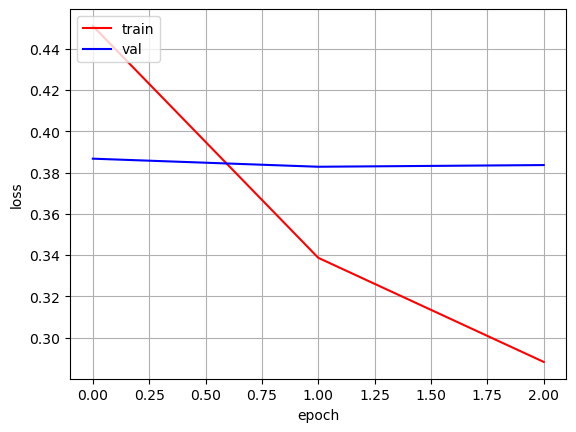

In [19]:
plt.plot(history.history['loss'], c='r')
plt.plot(history.history['val_loss'], c='b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()

plt.show()

In [20]:
test_metrics()

68.4739

In [26]:
def translate(text, n_translations=3):
    inputs = tokenizer(text, return_tensors='tf').input_ids
    outputs = model.generate(inputs, max_new_tokens=10, num_return_sequences=n_translations)

    for output in outputs:
        print(tokenizer.decode(output, skip_special_tokens=True))

In [33]:
translate('buenos dias')

Good morning.
good morning.
Good day.


In [27]:
translate('huella')

footprint
print
fingerprint


In [28]:
translate('huella dactilar')

fingerprint
Fingerprint
fingerprint


In [29]:
translate('secuaz')

henchman
Henchman
henchman.


In [30]:
translate('secuaces')

minions
henchmen
minnows


In [31]:
translate('desalojar')

evict
evicting
Evicting


In [34]:
translate('fingir')

pretend.
Pretend.
pretend


In [37]:
translate('ellos saben que no es tan lejos')

They know it's not that far.
They know it's not that far
They know it isn't that far.


In [40]:
translate('una maquina que puede aprender')

a machine that can learn
a machine that can learn.
a machine which can learn


In [35]:
translate('cuando como como como, como como caballo')

When I eat, I eat like a horse
when I eat like, like a horse
when I eat like, like a horse.
